Based on <em> Demonstration of maximum-likelihood reconstruction with SIRF <\em>

# Initial set-up

In [95]:
#%% make sure figures appears inline and animations works
%matplotlib inline

# Setup the working directory for the notebook
import notebook_setup
from sirf_exercises import cd_to_working_dir
cd_to_working_dir('PET', 'ML_reconstruction')

In [96]:
#%% Initial imports etc
import numpy as np
import scipy.stats
from scipy import ndimage
from scipy.ndimage import affine_transform
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import sys
import shutil
from numba import njit, prange
#import scipy
#from scipy import optimize
import sirf.STIR as pet
import sirf.Reg as reg
from sirf.Utilities import examples_data_path
from sirf_exercises import exercises_data_path
pet.set_verbosity(0)

# increase dpi of matplotlib figures
plt.rcParams['figure.dpi'] = 150

# define the directory with input files for this notebook
data_path = os.path.join(examples_data_path('PET'), 'thorax_single_slice')

In [97]:
# set-up redirection of STIR messages to files
msg_red = pet.MessageRedirector('info.txt', 'warnings.txt', 'errors.txt')

In [98]:
#%% some handy function definitions
def plot_2d_image(idx,vol,title,clims=None,cmap="viridis"):
    """Customized version of subplot to plot 2D image"""
    plt.subplot(*idx)
    plt.imshow(vol,cmap=cmap)
    if not clims is None:
        plt.clim(clims)
    plt.colorbar(shrink=.4)
    plt.title(title)
    plt.axis("off")

def make_positive(image_array):
    """truncate any negatives to zero"""
    image_array[image_array<0] = 0
    return image_array

def make_cylindrical_FOV(image):
    """truncate to cylindrical FOV"""
    filter = pet.TruncateToCylinderProcessor()
    filter.apply(image)

## Create some simulated data from ground-truth images
This is a repetition of the code in the OSEM notebook, just such that the current notebook is self-contained. However, there are no explanations here.

You should be able to adapt the notebook to use your own data as well of course. The actual reconstruction exercises and its evaluation does not require that the input is a simulation.

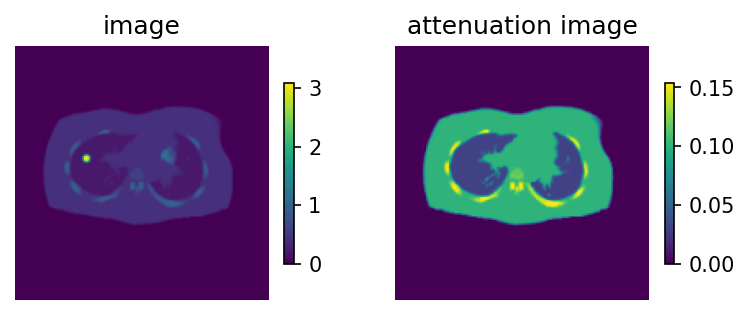

In [99]:
#%% Read in images
image = pet.ImageData(os.path.join(data_path, 'emission.hv'))*0.05
attn_image = pet.ImageData(os.path.join(data_path, 'attenuation.hv'))
template = pet.AcquisitionData(os.path.join(data_path, 'template_sinogram.hs'))
plt.figure()
plot_2d_image([1,2,1], image.as_array()[0,:], "image")
plot_2d_image([1,2,2], attn_image.as_array()[0,:], "attenuation image")
plt.show()

In [100]:
#%% save max for future displays
cmax = image.max()*.6

We are going to start creating our detector model. A PET (or SPECT or CT or...) acquisition process is characterised by a system matrix, $\mathcal{A}$, as well as additive contributions consisting of scatter and random coincidences:
$$f = \mathcal{A}u + s + r $$
Wwhere $f$ is our data, $u$ is our image and $s,r$ are our additive componatnts. We will only model the system matrix in this notebook.

Now, our system model is itself comprised of a number of different operations. We will concentrate on three of these: the radon transform, $\mathcal{R}$, attenuation, $A$, and detector normalisation $\mathcal{N}$, giving us:
$$ \mathcal{A} \approx \mathcal{N} A \mathcal{R} $$
where attenuation corrections and normalisation and multiplicative factors in the projection domain. \
And so our next job is to use SIRF's software to build this acquisition model

In [101]:
# create acquisition model matrix (this uses something called ray tracing, which you can ignore for this example)
# This is a 3-D (or in our case 2-D) Radon Transform matrix
acq_model_matrix  = pet.RayTracingMatrix()
# we will increase the number of rays used for every Line-of-Response (LOR) as an example
# (it is not required for the exercise of course)
acq_model_matrix.set_num_tangential_LORs(5)
# We can now create the acquisition model using this matrix
acq_model = pet.AcquisitionModelUsingMatrix(acq_model_matrix)

And we have $\mathcal{A} \approx \mathcal{R} $ 

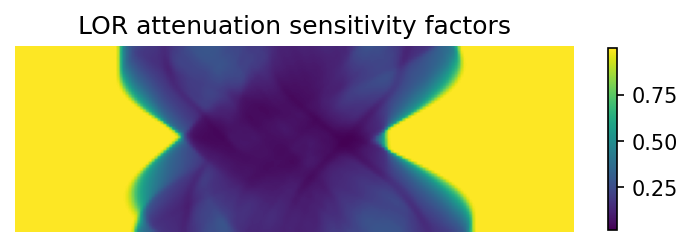

In [102]:
# We will now create the acquisition sensitivity model - a sinogram containing the sensitivity of each LOR. T
# This will depend on individual detector efficiencies, the geometry of the scanner, and the attenuation image
acq_model_for_attn = pet.AcquisitionModelUsingRayTracingMatrix() # this saves us a line of code but is the same as in the previous cell
# We now create the sensitivity model using the acquisition model and the attenuation image
asm_attn = pet.AcquisitionSensitivityModel(attn_image, acq_model_for_attn)
asm_attn.set_up(template)
# we can now find the attenuation sensitivity factors for each LOR by forward projecting a uniform image.
# We can set the value of this uniform image to be our detector efficiency. For now, let's just use 1.
attn_factors = asm_attn.forward(template.get_uniform_copy(1))
plt.figure()
plot_2d_image([1,1,1], attn_factors.as_array()[0,0,:], "LOR attenuation sensitivity factors")

This "image" looks a bit funny. Hopefully you've done some reading into this already, but this is what's know as a sinogram (because of the sinusoidal shape) and consists of 2D views of the object from different angles stacked on top of eachother. It's basicall what our detectors 'see' from a uniform image of 1.

In [103]:
# And then add the detector sensitivity (based on the attenuation image) that we made previously
acq_model.set_acquisition_sensitivity(asm_attn)
# set-up
acq_model.set_up(template,image)

And we now have $\mathcal{A} \approx \mathcal{N} A \mathcal{R} $. 

We can then see how this system will forward project our image and use this to simulate some data

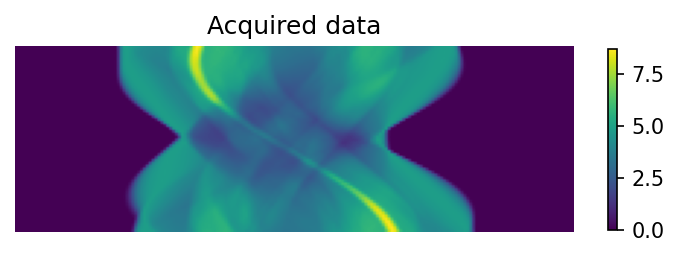

In [104]:
#%% simulate some data using forward projection
acquired_data=acq_model.forward(image)
plot_2d_image([1,1,1], acquired_data.as_array()[0,0,:], "Acquired data")

In [105]:
def add_noise(proj_data,noise_factor = 0.1, seed = 50):
    """Add Poission noise to acquisition data."""
    proj_data_arr = proj_data.as_array() / noise_factor
    # Data should be >=0 anyway, but add abs just to be safe
    np.random.seed(seed)
    noisy_proj_data_arr = np.random.poisson(proj_data_arr).astype('float32');
    noisy_proj_data = proj_data.clone()
    noisy_proj_data.fill(noisy_proj_data_arr*noise_factor);
    return noisy_proj_data

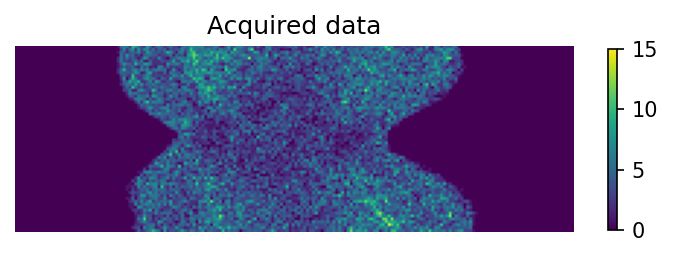

In [139]:
noisy_data = add_noise(acquired_data,1)
plot_2d_image([1,1,1], noisy_data.as_array()[0,0,:], "Acquired data")

OK and we have some simulated data. We have added poisson noise because of photon counting statistics where we either detect a count or we don't. An example of a poisson distribution with a mean of 2 and 10,000 counts is shown below

175.46736976785067

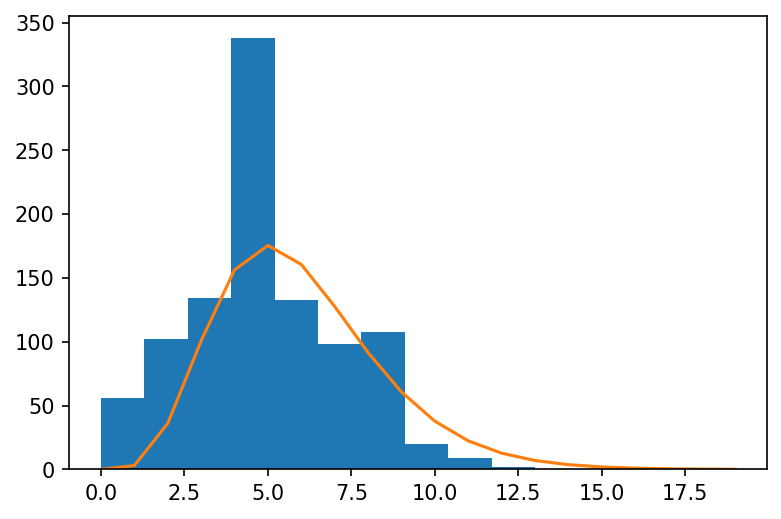

In [107]:
num_data = 1000
data = np.random.poisson(5, num_data)
poisson_fit = scipy.stats.poisson.pmf(5, np.arange(0, 20))*num_data
plt.hist(data)
plt.plot(poisson_fit)
np.max(poisson_fit)

Now, back to our sensitivity image. We can either treat our sensitivity such that we correct in the projection data space as above or we can correct in our image space:
$$ \mathcal{A} = \mathcal{R} A \mathcal{N} $$

This sensitivity image will look like the backprojection of a uniform sinogram of ones

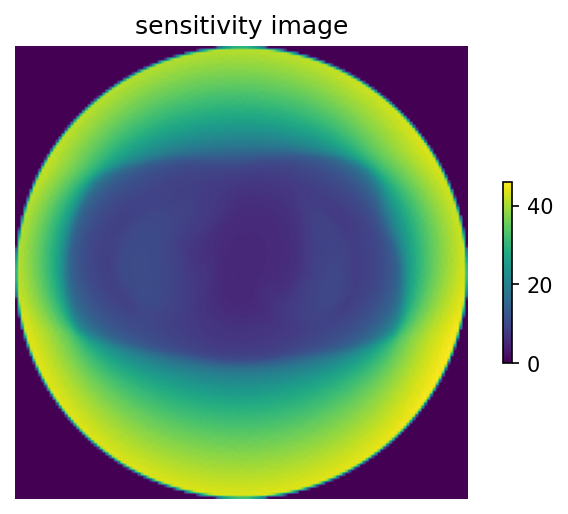

In [108]:
sens_image = acq_model.backward(template.get_uniform_copy(1))
plot_2d_image([1,1,1], sens_image.as_array()[0,:], "sensitivity image")

Now, lets have a look at what can happen to our sensitivity image (or attenuation factors) if we have a misaligned object

In [109]:
s_geom_info = attn_image.get_geometrical_info()
A_LPH = s_geom_info.get_index_to_physical_point_matrix()  # 4x4 affine matrix

/home/sam/devel/build/INSTALL/python/sirf/SIRF.py:704: UserWarning: geometrical info for STIR.ImageData might be incorrect
  warnings.warn("geometrical info for STIR.ImageData might be incorrect")


In [110]:
def affine_transform_2D(theta, tx, ty, sx, sy, image_arr):
    ''' create a random affine transformation for 2D images '''
    # create the transformation matrix
    transformation_matrix = np.array([[sx*np.cos(theta), -sy*np.sin(theta), tx],
                                        [sx*np.sin(theta),  sy*np.cos(theta), ty],
                                        [0, 0, 1]])

    # apply the transformation
    image_arr_transformed = affine_transform(image_arr, transformation_matrix, order=1)
    return image_arr_transformed

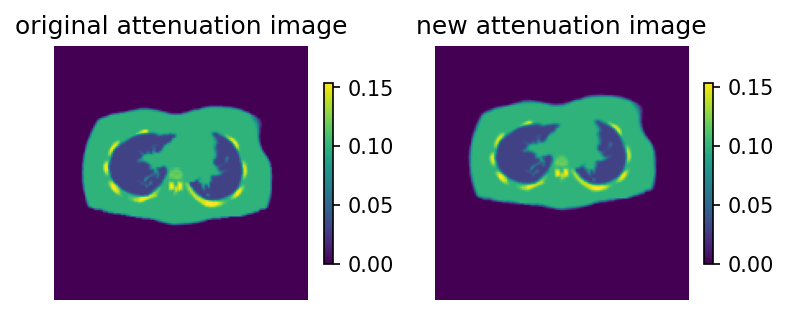

In [111]:
vol = attn_image.as_array()

# apply a random affine transformation using np.random
theta = np.random.uniform(-np.pi/32, np.pi/32)
tx, ty = np.random.uniform(-1, 1), np.random.uniform(-1, 1)
sx, sy = np.random.uniform(0.98, 1.08), np.random.uniform(0.98, 1.08)
vol_transformed = affine_transform_2D(theta, tx, ty, sx, sy, vol[0,:])

vol_transformed = np.expand_dims(vol_transformed, axis=0)

attn_image_new = attn_image.clone().fill(vol_transformed)

vol = attn_image.as_array()
vol_transformed = affine_transform_2D(theta, tx, ty, sx, sy, vol[0,:])
vol_transformed = np.expand_dims(vol_transformed, axis=0)

image_new = image.clone().fill(vol_transformed)

plt.figure()
plot_2d_image([1,2,1], attn_image.as_array()[0,:], "original attenuation image")
plot_2d_image([1,2,2], attn_image_new.as_array()[0,:], "new attenuation image")
plt.show()

In [112]:
acq_model_for_attn_new = pet.AcquisitionModelUsingRayTracingMatrix() # this saves us a line of code but is the same as in the previous cell
# We now create the sensitivity model using the acquisition model and the attenuation image
asm_attn_new = pet.AcquisitionSensitivityModel(attn_image_new, acq_model_for_attn_new)
asm_attn_new.set_up(template)
attn_factors_new = asm_attn_new.forward(template.get_uniform_copy(1))
# And then add the detector sensitivity (based on the attenuation image) that we made previously
acq_model_new = pet.AcquisitionModelUsingRayTracingMatrix()
acq_model_new.set_acquisition_sensitivity(asm_attn_new)
# set-up
acq_model_new.set_up(template,image)
sens_image_new = acq_model_new.backward(template.get_uniform_copy(1))

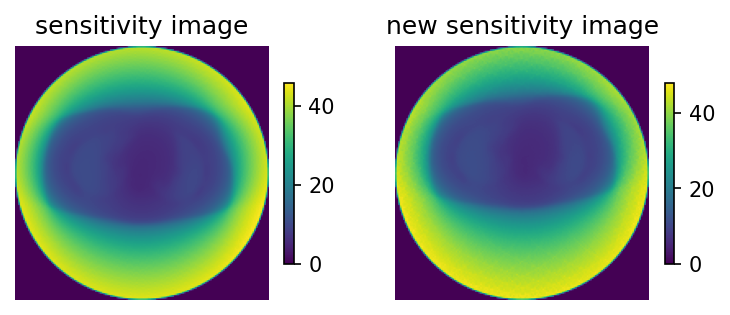

In [113]:
plt.figure()
plot_2d_image([1,2,1], sens_image.as_array()[0,:], "sensitivity image")
plot_2d_image([1,2,2], sens_image_new.as_array()[0,:], "new sensitivity image")
plt.show()

Now let's compare a few reconstructions with our old and new sensitivity images. We'll use a home-made OSEM to highlight this

Firstly, let's write a quick function to deal with zero division errors outsiude of the FoV. We're using a parallel programming functionality called numba. This can be ignored. We're just setting pixels outside the FoV to zero

In [114]:
def sensitivity_division(arr1, arr2):
    tmp  = np.zeros_like(arr1).flatten()
    for i in prange(tmp.size):
        if arr2.flatten()[i] != 0:
            tmp[i] = arr1.flatten()[i]/arr2.flatten()[i]
        else:
            tmp[i] = 0
    return tmp.reshape(arr1.shape)

Next we'll create a function to perform a step of the Maximum Likelihood Expectation Maximisation

In [115]:
# This function performs a single MLEM update
def MLEM_step(input_image, acq_model, acquired_data, sensitivity_image_array):
    # forward projection
    forward_projected_data = acq_model.forward(input_image)
    # divide acquired data by forward projected data
    ratio = acquired_data / forward_projected_data
    # back projection
    back_projected_data = acq_model.backward(ratio).as_array()
    # divide by sensitivity image
    back_projected_data_array = sensitivity_division(back_projected_data, sensitivity_image_array)
    # update input image
    output_image = input_image*input_image.clone().fill(back_projected_data_array)
    return output_image


## create initial image

In the previous OSEM notebook, we just used a uniform image. Here, we will use a disk that roughly corresponds to the *Field of View (FOV)*. The reason for this is that it makes things easier for display and the gradient ascent code below.

An alternative solution would be to tell the `acq_model` to use a square FOV as opposed to a circular one, but that will slow down calculations just a little bit, so we won't do that here (feel free to try!).

In addition, the initial value is going to be a bit more important here as we're going to plot the value of the objective function. Obviously, having a descent estimate of the scale of the image will make that plot look more sensible. Feel free to experiment with the value!

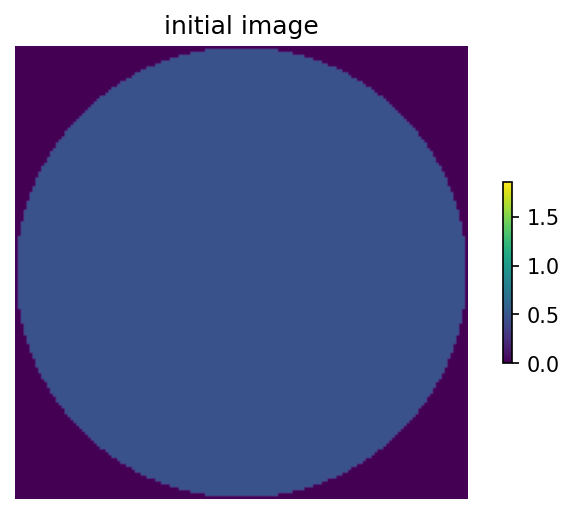

In [116]:
initial_image=image.get_uniform_copy(cmax / 4)
make_cylindrical_FOV(initial_image)
# display
im_slice = initial_image.dimensions()[0] // 2
plt.figure()
plot_2d_image([1,1,1],initial_image.as_array()[im_slice,:,:], 'initial image',[0,cmax])

In [117]:
obj_fun = pet.make_Poisson_loglikelihood(noisy_data)
obj_fun.set_acquisition_model(acq_model)
obj_fun.set_acquisition_data(noisy_data)
obj_fun.set_up(image)

In [118]:
radon_transform = pet.AcquisitionModelUsingRayTracingMatrix()
radon_transform.set_up(template, image)

In [119]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values = [obj_fun.value(current_image)]

# create an ndarray to store the images at every sub-iteration
all_osem_images = np.ndarray(shape=(num_iters + 1,) + current_image.dimensions())
all_osem_images[0,:,:,:] = current_image.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image = MLEM_step(current_image, radon_transform, acquired_data, sens_image.as_array())
    # store results
    obj_fun_value = obj_fun.value(current_image)
    osem_objective_function_values.append(obj_fun_value)
    all_osem_images[i,:,:,:] =  current_image.as_array()

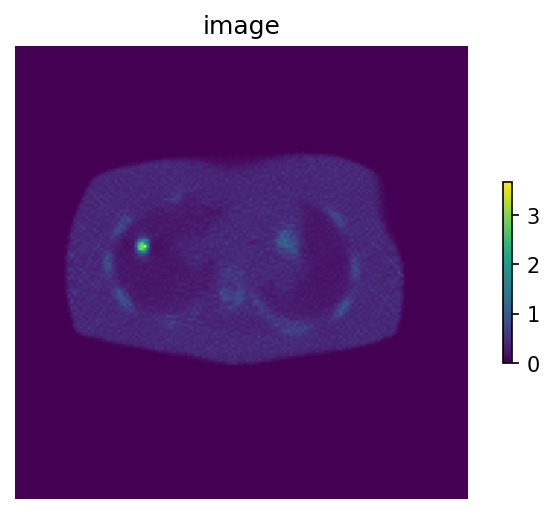

In [120]:
plot_2d_image([1,1,1], all_osem_images[-1][0,:], "image")

## Make some plots with these results

In [121]:
#%% define a function for plotting images and the updates
def plot_progress(all_images, title, ground_truth, subiterations = [], max = cmax):
    ground_truth_array = ground_truth.as_array()
    if len(subiterations) == 0:
        num_subiters = all_images[0].shape[0] - 1
        subiterations = range(1, num_subiters + 1)
    num_rows = len(all_images)

    for i in subiterations:
        plt.figure()
        for r in range(num_rows):
            plot_2d_image([num_rows,3,3 * r + 1],
                          all_images[r][i,im_slice,:,:],'%s at %d' % (title[r], i), [0,max])
            plot_2d_image([num_rows,3,3*r+2],
                          all_images[r][i,im_slice,:,:]-all_images[r][i - 1,im_slice,:,:],'update',[-max*.05,max*.05], cmap='seismic')
            plot_2d_image([num_rows,3,3*r+3],
                          all_images[r][i,im_slice,:,:]-ground_truth_array[im_slice,:,:],'error',[-max*.25,max*.25], cmap='seismic')
        plt.show()

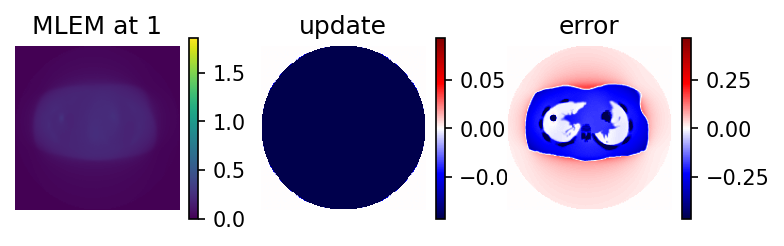

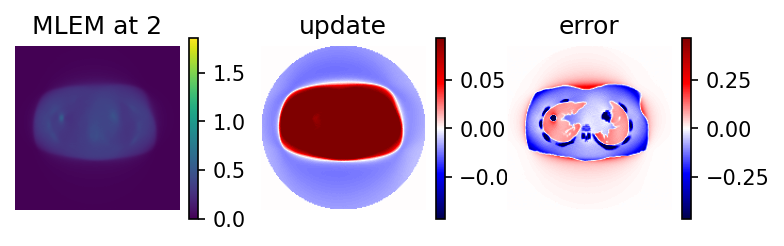

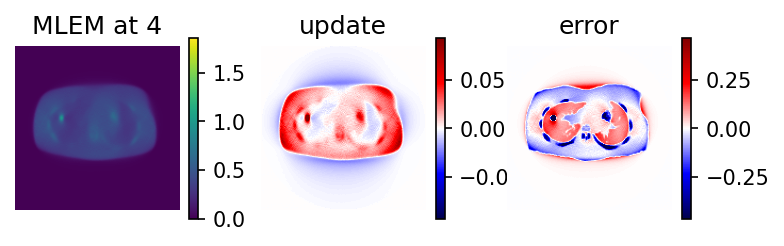

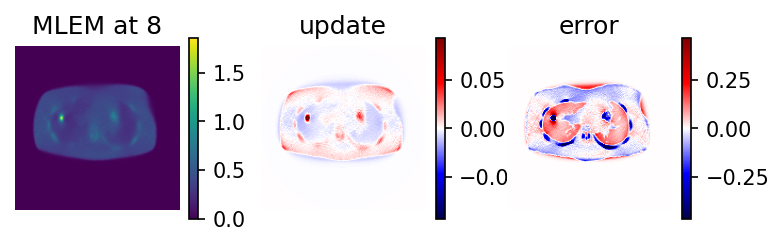

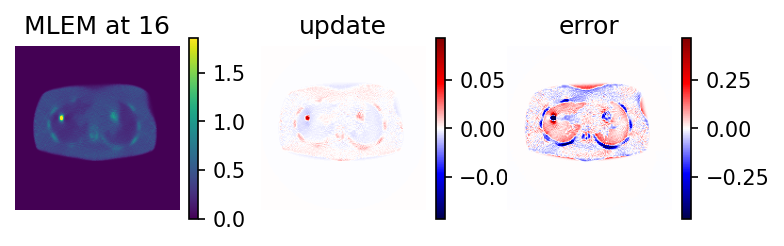

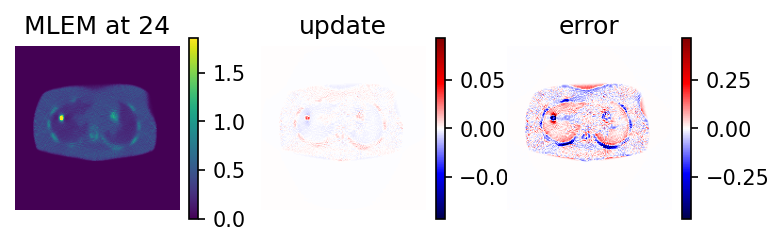

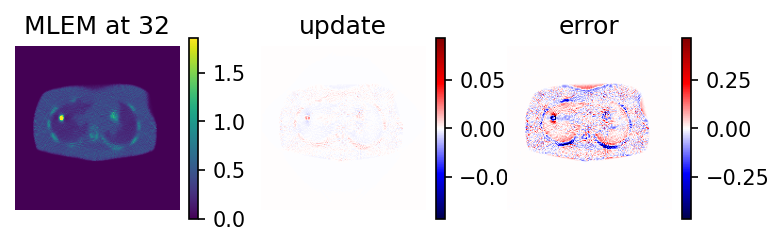

In [122]:
#%% now call this function to see how we went along
# note that in the notebook interface, this might create a box with a vertical slider
subiterations = (1,2,4,8,16,24,32)
# close all "open" images as otherwise we will get warnings (the notebook interface keeps them "open" somehow)
plt.close('all')    
plot_progress([all_osem_images], ['MLEM'],image, subiterations)

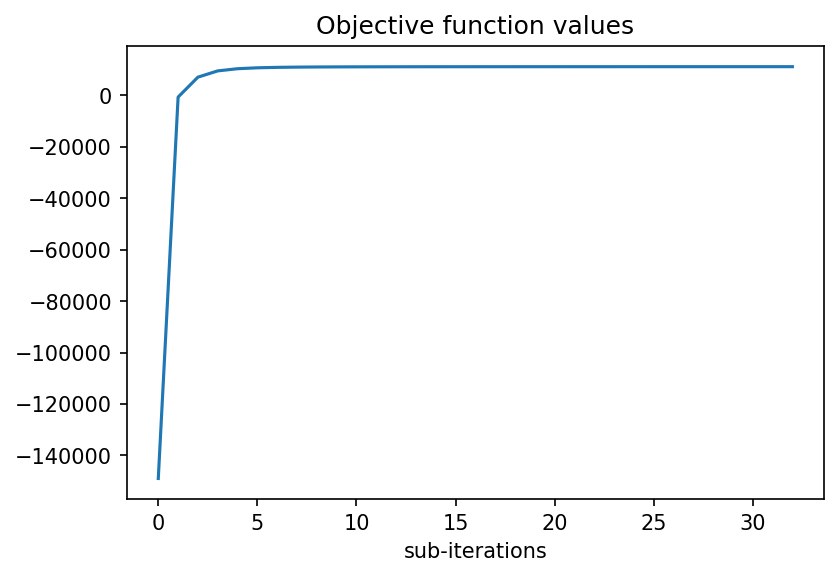

In [123]:
#%% plot objective function values
plt.figure()
#plt.plot(subiterations, [ osem_objective_function_values[i] for i in subiterations])
plt.plot(osem_objective_function_values)
plt.title('Objective function values')
plt.xlabel('sub-iterations');

OK. so let's now compare this to a reconstruction with the offset image, but with the original sensitivity image. We'll then compare this to a reconstruction with the correct sensitivity image

In [140]:
noisy_data_new = add_noise(acq_model_new.forward(image_new),1)

In [141]:
obj_fun_new = pet.make_Poisson_loglikelihood(noisy_data_new)
obj_fun_new.set_acquisition_model(acq_model_new)
obj_fun_new.set_acquisition_data(noisy_data_new)
obj_fun_new.set_up(image_new)

In [142]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values_new = [obj_fun.value(current_image)]

# create an ndarray to store the images at every sub-iteration
all_osem_images_new = np.ndarray(shape=(num_iters + 1,) + current_image.dimensions())
all_osem_images_new[0,:,:,:] = current_image.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image = MLEM_step(current_image, radon_transform, noisy_data_new, sens_image.as_array())
    # store results
    obj_fun_value = obj_fun_new.value(current_image)
    osem_objective_function_values_new.append(obj_fun_value)
    all_osem_images_new[i,:,:,:] =  current_image.as_array()

In [143]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values_new_corr = [obj_fun.value(current_image)]

# create an ndarray to store the images at every sub-iteration
all_osem_images_new_corr = np.ndarray(shape=(num_iters + 1,) + current_image.dimensions())
all_osem_images_new_corr[0,:,:,:] = current_image.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image = MLEM_step(current_image, radon_transform, noisy_data_new, sens_image_new.as_array())
    # store results
    obj_fun_value = obj_fun_new.value(current_image)
    osem_objective_function_values_new_corr.append(obj_fun_value)
    all_osem_images_new_corr[i,:,:,:] =  current_image.as_array()

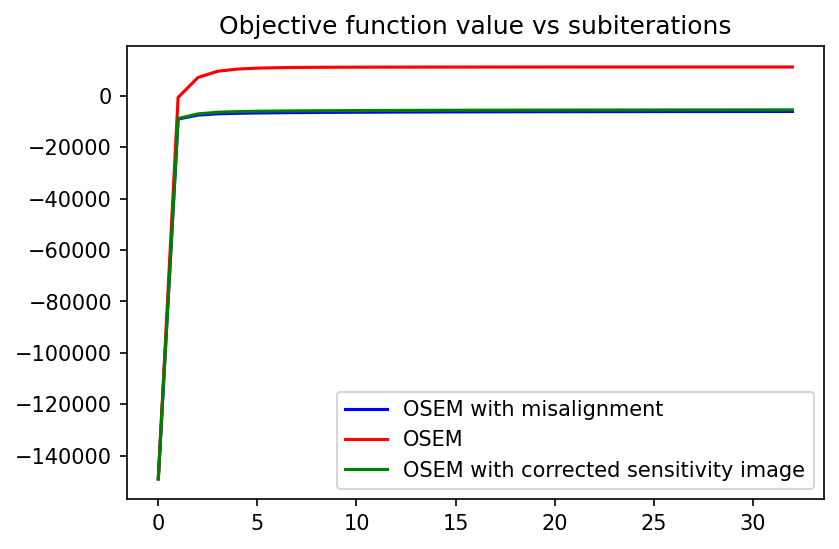

In [144]:
#%% Plot objective function values
plt.figure()
#plt.hold('on')
plt.title('Objective function value vs subiterations')
plt.plot(osem_objective_function_values_new,'b')
plt.plot(osem_objective_function_values,'r')
plt.plot(osem_objective_function_values_new_corr,'g')
plt.legend(('OSEM with misalignment', 'OSEM', 'OSEM with corrected sensitivity image'),loc='lower right');

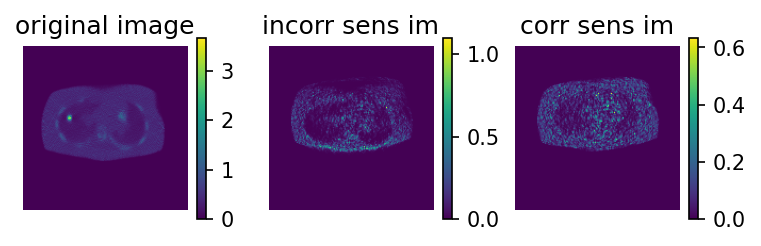

In [129]:
plot_2d_image([1,3,1], all_osem_images[-1][0,:], "original image")
plot_2d_image([1,3,2], all_osem_images_new[-1][0,:], "incorr sens im")
plot_2d_image([1,3,3], all_osem_images_new_corr[-1][0,:], "corr sens im")

This has shown us that there can be a large deviation in reconstructed image if the sensitivity image is incorrect. So how can we fix this? One method is to `gate` our acquisition into groups of timepoint with similar attenuation maps (i.e patient positions). We can then calculate a sensitivity image for all these timepoints. However, this could lead to long calculation times.

We could therefore use a neural network to output a the required change in a sensitivity image based on the change in an attenuation image.

In [145]:
# Import a file that can generate the shepp logan phantom
from odl_funcs.ellipses import EllipsesDataset
# Import standard extra packages
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.optim as optim

mini_batch = 10
from sirf.Utilities import examples_data_path

In [146]:
from odl_funcs.misc import *

In [147]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

class SimpleCNN(nn.Module):
    """ 
    A CNN for PET sensitivity estimation.
    Consists of 3 convolutional layers with ReLU activation. 
    Kernel sizes are 15x15, 9x9, 5x5, 3x3, 3x3, 7x7, 15x15, 3x3, 3x3 with padding 
    The idea of this is to have a large kernel size at the beginning to capture
    the large motion, and then gradually reduce the kernel size to capture the
    smaller motion.
    The kernel sizes then increases again to provide an edge filtering effect on a blurry image
    Input:
        2 images (sensitivity with no motion and attenuation correction map)
    Output:
        1 image (sensitivity with motion)
    """

    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, 15, padding=7)
        self.conv2 = nn.Conv2d(16, 32, 9, padding=4)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 32, 7, padding=3)
        self.conv6 = nn.Conv2d(32, 16, 15, padding=7)
        self.conv7 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv8 = nn.Conv2d(16, 1, 3, padding=1)

    def forward(self, x):
        x[:,1,:,:]=x[:,1,:,:].mul(10)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        return x

In [148]:
mini_batch = 2
train_dataloader = torch.utils.data.DataLoader( \
    EllipsesDataset(radon_transform, attn_image, template, mode="train", n_samples = 20) \
    , batch_size=mini_batch, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader( \
    EllipsesDataset(radon_transform, attn_image, template, mode="valid", n_samples = 6) \
    , batch_size=mini_batch, shuffle=False)

In [150]:
loss_function = nn.MSELoss()
model = SimpleCNN()
optimizer = optim.Adam(model.parameters(), lr=0.0000001) # really small learning rate because we should be (almost) at the optimum already

In [151]:
model.load_state_dict(torch.load("/home/sam/working/SIRF-Exercises/notebooks/PET_sensitivity/model_CNN.pt", map_location=device))
model.eval()
model.to(device)

RuntimeError: Error(s) in loading state_dict for SimpleCNN:
	size mismatch for conv1.weight: copying a param with shape torch.Size([16, 2, 11, 11]) from checkpoint, the shape in current model is torch.Size([16, 2, 15, 15]).
	size mismatch for conv2.weight: copying a param with shape torch.Size([32, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 16, 9, 9]).

In [ ]:
train_loss_history = []
valid_loss_history = []

for epoch in range(3): # 3full passes over the data
    for data, validation in zip(train_dataloader, valid_dataloader):  # `data` is a batch of data
        X, y = data  # X is the batch of features, y is the batch of targets.
        model.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
        output = model(X.to(device))  # pass in the reshaped batch
        loss = loss_function(output, y.to(device))  # calc and grab the loss value
        train_loss_history.append(loss)
        #valid_loss_history.append(loss_function(net(validation[0].to(device)), validation[1].to(device)))
        loss.backward()  # apply this loss backwards thru the network's parameters
        optimizer.step()  # attempt to optimize weights to account for loss/gradients
    print(loss)  # print loss. We hope loss (a measure of wrong-ness) declines! 


	attenuation image data are supposed to be in units cm^-1
	Reference: water has mu .096 cm^-1
	Max in attenuation image: 0.210564
	Continuing as you might know what you are doing.

	attenuation image data are supposed to be in units cm^-1
	Reference: water has mu .096 cm^-1
	Max in attenuation image: 0.209927
	Continuing as you might know what you are doing.


tensor(57.9227, device='cuda:0', grad_fn=<MseLossBackward0>)



	attenuation image data are supposed to be in units cm^-1
	Reference: water has mu .096 cm^-1
	Max in attenuation image: 0.207687
	Continuing as you might know what you are doing.

	attenuation image data are supposed to be in units cm^-1
	Reference: water has mu .096 cm^-1
	Max in attenuation image: 0.238951
	Continuing as you might know what you are doing.

	attenuation image data are supposed to be in units cm^-1
	Reference: water has mu .096 cm^-1
	Max in attenuation image: 0.238951
	Continuing as you might know what you are doing.

	attenuation image data are supposed to be in units cm^-1
	Reference: water has mu .096 cm^-1
	Max in attenuation image: 0.0757148
	Continuing as you might know what you are doing.

	attenuation image data are supposed to be in units cm^-1
	Reference: water has mu .096 cm^-1
	Max in attenuation image: 0.0668723
	Continuing as you might know what you are doing.


tensor(101.6578, device='cuda:0', grad_fn=<MseLossBackward0>)



	attenuation image data are supposed to be in units cm^-1
	Reference: water has mu .096 cm^-1
	Max in attenuation image: 0.255776
	Continuing as you might know what you are doing.

	attenuation image data are supposed to be in units cm^-1
	Reference: water has mu .096 cm^-1
	Max in attenuation image: 0.255776
	Continuing as you might know what you are doing.

	attenuation image data are supposed to be in units cm^-1
	Reference: water has mu .096 cm^-1
	Max in attenuation image: 0.219614
	Continuing as you might know what you are doing.


tensor(85.7233, device='cuda:0', grad_fn=<MseLossBackward0>)


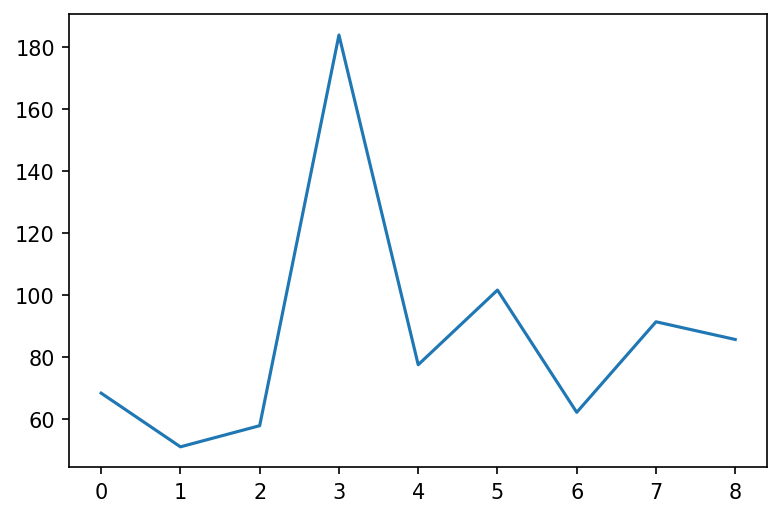

In [ ]:
loss_history=[]
for i in train_loss_history:
    loss_history.append(i.item())
plt.plot(loss_history)

This was already converged, which is why you see this flat, noisy line here

In [ ]:
input_data = torch.from_numpy(np.squeeze(np.array([sens_image.as_array(), attn_image_new.as_array()-attn_image.as_array()]))).unsqueeze(0)
input_data = input_data.to(device)

In [ ]:
out = model(input_data)

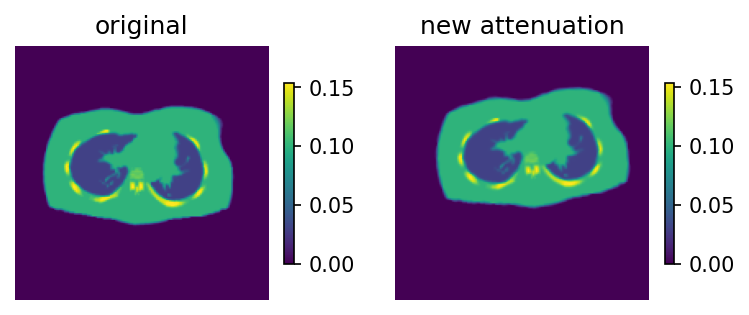

In [ ]:
plot_2d_image([1,2,1],attn_image.as_array()[0,:,:], "original")
plot_2d_image([1,2,2],attn_image_new.as_array()[0,:,:], "new attenuation")

Well, our network hasn't really worked. This could be an issue with the architecture, the data or, more than likely, both of these and more! Luckily we have plenty of time to mess around with these things

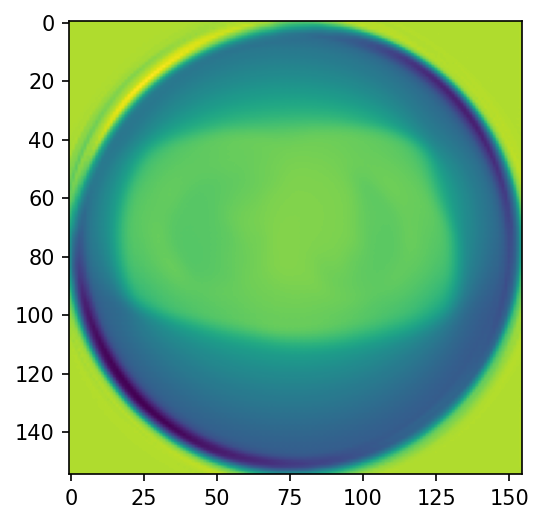

In [ ]:
sens_image_NN = initial_image.clone().fill(out.cpu()[0,:,:,:].detach().numpy())
plt.imshow(sens_image_NN.as_array()[0,:,:])

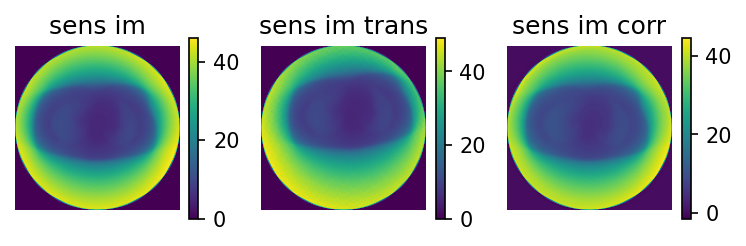

In [ ]:


plot_2d_image([1,3,1], sens_image.as_array()[0,:,:], 'sens im', cmap="viridis")
plot_2d_image([1,3,2], sens_image_new.as_array()[0,:,:], 'sens im trans', cmap="viridis")
plot_2d_image([1,3,3], (sens_image_NN+sens_image).as_array()[0,:,:], 'sens im corr', cmap="viridis")

In [ ]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image_NN = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values_NN = [obj_fun.value(current_image_NN)]

# create an ndarray to store the images at every sub-iteration
all_osem_images_NN = np.ndarray(shape=(num_iters + 1,) + current_image_NN.dimensions())
all_osem_images_NN[0,:,:,:] = current_image_NN.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image_NN = MLEM_step(current_image_NN, radon_transform, noisy_data, sens_image_NN.as_array())
    # store results
    obj_fun_value = obj_fun.value(current_image_NN)
    osem_objective_function_values_NN.append(obj_fun_value)
    all_osem_images_NN[i,:,:,:] =  current_image_NN.as_array()

And that was surprisingly good! There's some definite blurring - how could we sharpen this up?

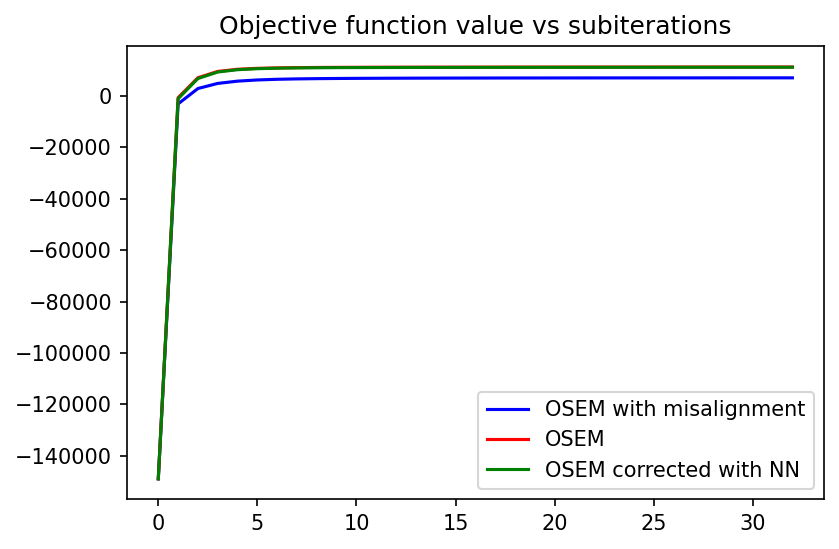

In [ ]:
#%% Plot objective function values
plt.figure()
#plt.hold('on')
plt.title('Objective function value vs subiterations')
plt.plot(osem_objective_function_values_new,'b')
plt.plot(osem_objective_function_values,'r')
plt.plot(osem_objective_function_values_NN,'g')
plt.legend(('OSEM with misalignment', 'OSEM', 'OSEM corrected with NN'),loc='lower right');

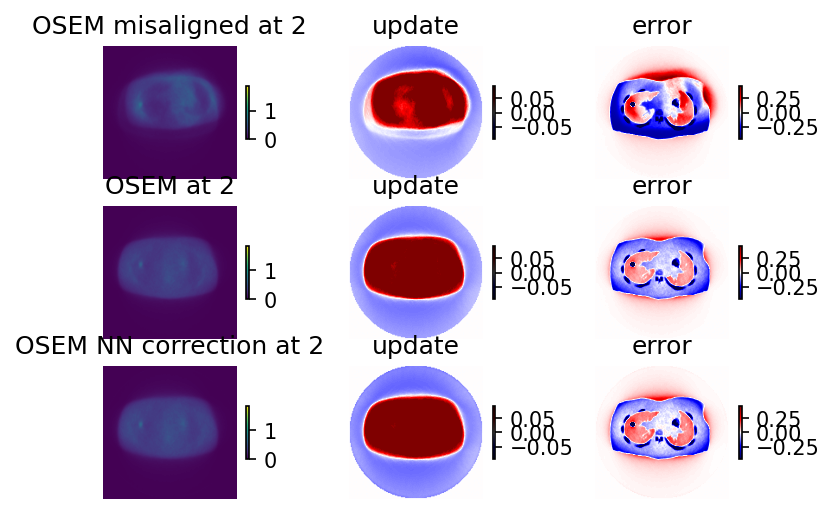

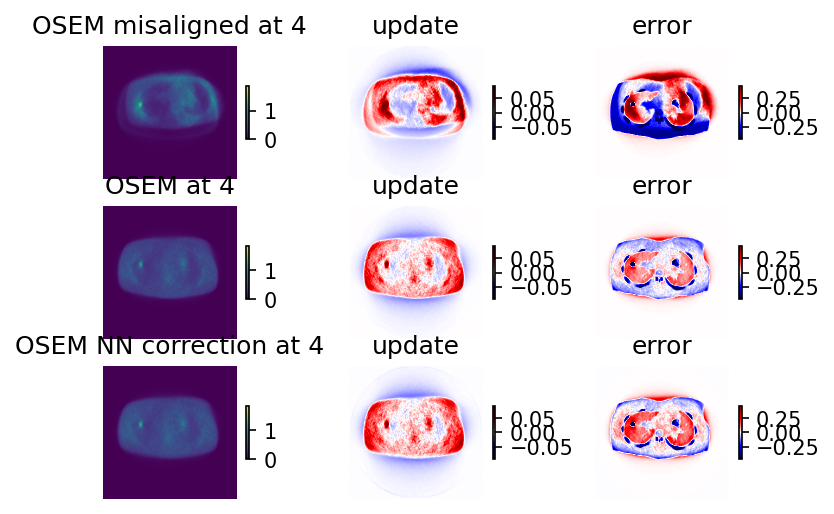

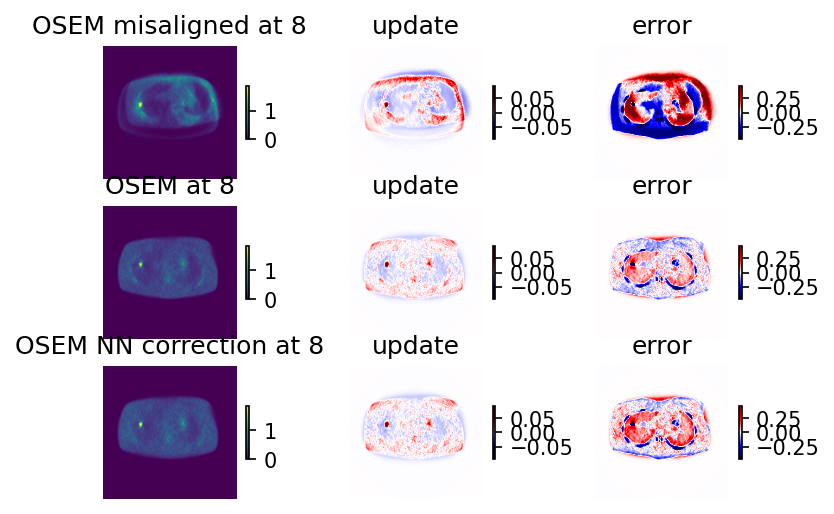

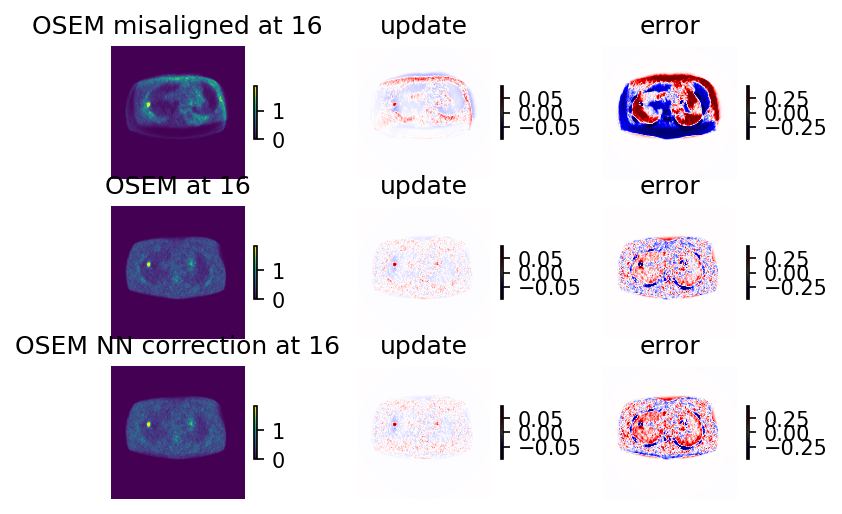

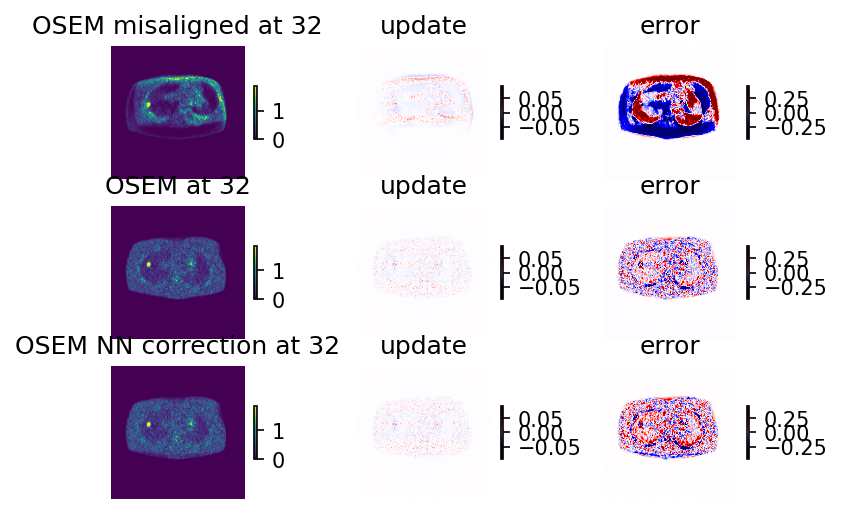

In [ ]:
#%% compare GA and OSEM images
plot_progress([all_osem_images_new, all_osem_images, all_osem_images_NN], ['OSEM misaligned' ,'OSEM', 'OSEM NN correction'],image, [2,4,8,16,32])

And look at that. It's worked (a bit)! how good is that? Obviously this is a very simple network with very simple training data so we can still do a bit more

Let's try this with some brainweb data!

In [ ]:
# create PET and CT brain images using BrainWeb
# (see https://www.mccauslandcenter.sc.edu/mricro/mricron/brainweb.html)

import brainweb
from tqdm import tqdm
from scipy import ndimage


fname, url= sorted(brainweb.utils.LINKS.items())[0]
files = brainweb.get_file(fname, url, ".")
data = brainweb.load_file(fname)

brainweb.seed(1337)

for f in tqdm([fname], desc="mMR ground truths", unit="subject"):
    vol = brainweb.get_mmr_fromfile(f, petNoise=1, t1Noise=0.75, t2Noise=0.75, petSigma=1, t1Sigma=1, t2Sigma=1)

FDG_arr  = vol['PET']
T1_arr   = vol['T1']
uMap_arr = vol['uMap']

mMR ground truths: 100%|██████████| 1/1 [00:00<00:00,  4.32subject/s]


In [ ]:
def crop(img, cropx, cropy):
    z,y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[:, starty:starty+cropy,startx:startx+cropx]

In [ ]:
# function to zoom out and crop the brainweb images
fdg_zoomed = crop(ndimage.zoom(FDG_arr, 1, order=1), 155, 155)
fdg_brain_2D = fdg_zoomed[50,:,:]

t1_zoomed = crop(ndimage.zoom(T1_arr, 1, order=1), 155, 155)
t1_brain_2D = t1_zoomed[50,:,:]

umap_zoomed = crop(ndimage.zoom(uMap_arr, 1, order=1), 155, 155)
umap_brain_2D = umap_zoomed[50,:,:]


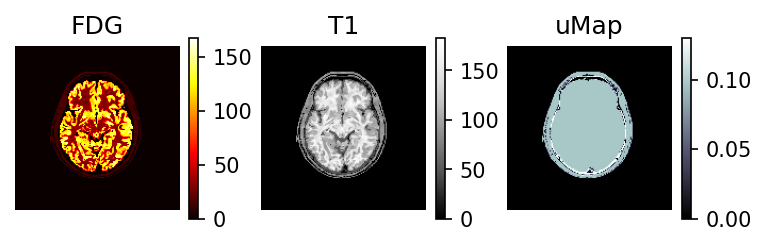

In [ ]:
# Display it
plt.figure();
slice_show = FDG_arr.shape[0]//2
plot_2d_image([1,3,1], fdg_brain_2D, 'FDG', cmap="hot")
plot_2d_image([1,3,2], t1_brain_2D, 'T1', cmap="Greys_r")
plot_2d_image([1,3,3], umap_brain_2D, 'uMap', cmap="bone")

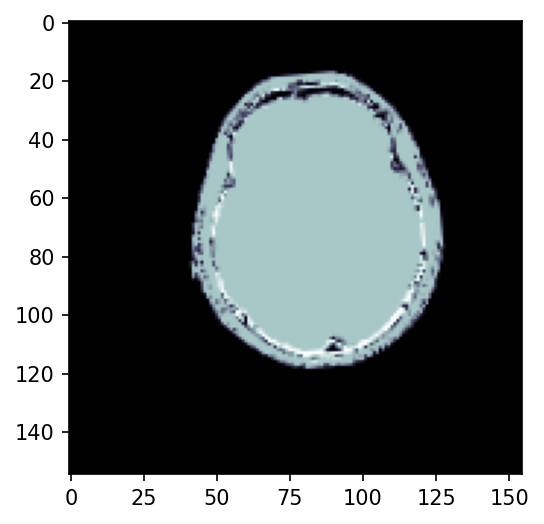

In [ ]:
# now let's add an affune transformation to the uMap
from scipy import ndimage
from scipy.ndimage import affine_transform

# create a random affine transformation for 2D images

# rotation
theta = np.random.uniform(-np.pi/16, np.pi/16)
# translation
tx = np.random.uniform(-0.5, 0.5)
ty = np.random.uniform(-0.5, 0.5)
# scaling
sx = np.random.uniform(0.95, 1.05)
sy = np.random.uniform(0.95, 1.05)

umap_brain_2D_transformed = affine_transform_2D(theta, tx, ty, sx, sy,umap_brain_2D)
# Display it
plt.imshow(umap_brain_2D_transformed, cmap="bone")

In [ ]:
fdg_brain_image = image.clone().fill(np.expand_dims(fdg_brain_2D, axis=0))
t1_brain_image = image.clone().fill(np.expand_dims(t1_brain_2D, axis=0))
umap_brain_image = image.clone().fill(np.expand_dims(umap_brain_2D, axis=0))
umap_brain_image_transformed = image.clone().fill(np.expand_dims(umap_brain_2D_transformed, axis=0))

In [ ]:
acq_model_brain = pet.AcquisitionModelUsingRayTracingMatrix()
acq_model_for_attn_brain = pet.AcquisitionModelUsingRayTracingMatrix() 
asm_attn_brain = pet.AcquisitionSensitivityModel(umap_brain_image, acq_model_for_attn_brain)
asm_attn_brain.set_up(template)
attn_factors_brain = asm_attn_brain.forward(template.get_uniform_copy(1))
asm_attn_brain = pet.AcquisitionSensitivityModel(attn_factors_brain)
acq_model_brain.set_acquisition_sensitivity(asm_attn_brain)
# set-up
acq_model_brain.set_up(template,fdg_brain_image)

In [ ]:
acq_model_brain_new = pet.AcquisitionModelUsingRayTracingMatrix()
acq_model_for_attn_brain_new = pet.AcquisitionModelUsingRayTracingMatrix()
asm_attn_brain_new = pet.AcquisitionSensitivityModel(umap_brain_image_transformed, acq_model_for_attn_brain_new)
asm_attn_brain_new.set_up(template)
attn_factors_brain_new = asm_attn_brain_new.forward(template.get_uniform_copy(1))
asm_attn_brain_new = pet.AcquisitionSensitivityModel(attn_factors_brain_new)
acq_model_brain_new.set_acquisition_sensitivity(asm_attn_brain_new)
# set-up
acq_model_brain_new.set_up(template,fdg_brain_image)

In [ ]:
sens_image_brain = acq_model_brain.backward(template.get_uniform_copy(1))
sens_image_brain_new = acq_model_brain_new.backward(template.get_uniform_copy(1))

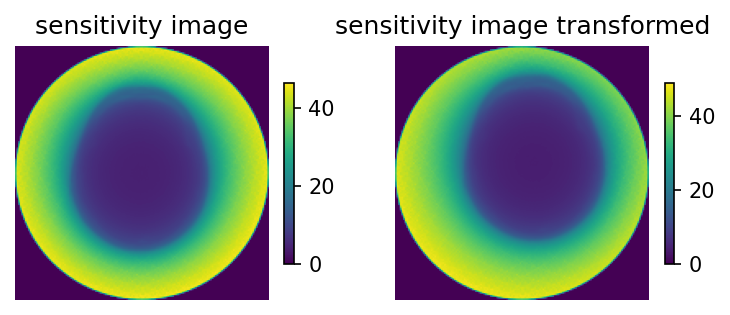

In [ ]:
plot_2d_image([1,2,1], sens_image_brain.as_array()[0,:,:], 'sensitivity image', cmap="viridis")
plot_2d_image([1,2,2], sens_image_brain_new.as_array()[0,:,:], 'sensitivity image transformed', cmap="viridis")

In [ ]:
acquired_data_brain = acq_model_brain.forward(fdg_brain_image)
acquired_data_brain_noisy = add_noise(acquired_data_brain, 0.1)

In [ ]:
# set up objective function and reconstructor  
obj_fun_brain = pet.make_Poisson_loglikelihood(acquired_data_brain_noisy)
obj_fun_brain.set_acquisition_model(acq_model_brain)
obj_fun_brain.set_num_subsets(1)
obj_fun_brain.set_up(fdg_brain_image)

In [ ]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values_brain = [obj_fun_brain.value(current_image)]

# create an ndarray to store the images at every sub-iteration
all_osem_images_brain = np.ndarray(shape=(num_iters + 1,) + current_image.dimensions())
all_osem_images_brain[0,:,:,:] = current_image.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image = MLEM_step(current_image, radon_transform, acquired_data_brain_noisy, sens_image_brain.as_array())
    # store results
    obj_fun_value = obj_fun_brain.value(current_image)
    osem_objective_function_values.append(obj_fun_value)
    all_osem_images_brain[i,:,:,:] =  current_image.as_array()

In [ ]:
# and now with the affine transformation image
num_iters = 32

# create an image object that will be updated during the iterations
current_image = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values_brain_new = [obj_fun_brain.value(current_image)]

# create an ndarray to store the images at every sub-iteration
all_osem_images_brain_new = np.ndarray(shape=(num_iters + 1,) + current_image.dimensions())
all_osem_images_brain_new[0,:,:,:] = current_image.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image = MLEM_step(current_image, radon_transform, acquired_data_brain_noisy, sens_image_brain_new.as_array())
    # store results
    obj_fun_value = obj_fun_brain.value(current_image)
    osem_objective_function_values.append(obj_fun_value)
    all_osem_images_brain_new[i,:,:,:] =  current_image.as_array()

In [ ]:
input_data = torch.from_numpy(np.squeeze(np.array([sens_image_brain.as_array(), umap_brain_image_transformed.as_array()]))).unsqueeze(0)
input_data = input_data.to(device)
out_brain = model(input_data)

In [ ]:
# and now with the corrected image
num_iters = 32

# create an image object that will be updated during the iterations
current_image = initial_image.clone()

sens_image_brain_NN = initial_image.clone().fill(out_brain.cpu()[0,:,:,:].detach().numpy())

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values_brain_corrected = [obj_fun_brain.value(current_image)]

# create an ndarray to store the images at every sub-iteration
all_osem_images_brain_corrected = np.ndarray(shape=(num_iters + 1,) + current_image.dimensions())
all_osem_images_brain_corrected[0,:,:,:] = current_image.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image = MLEM_step(current_image, radon_transform, acquired_data_brain_noisy, sens_image_brain_NN.as_array())
    # store results
    obj_fun_value = obj_fun_brain.value(current_image)
    osem_objective_function_values.append(obj_fun_value)
    all_osem_images_brain_corrected[i,:,:,:] =  current_image.as_array()

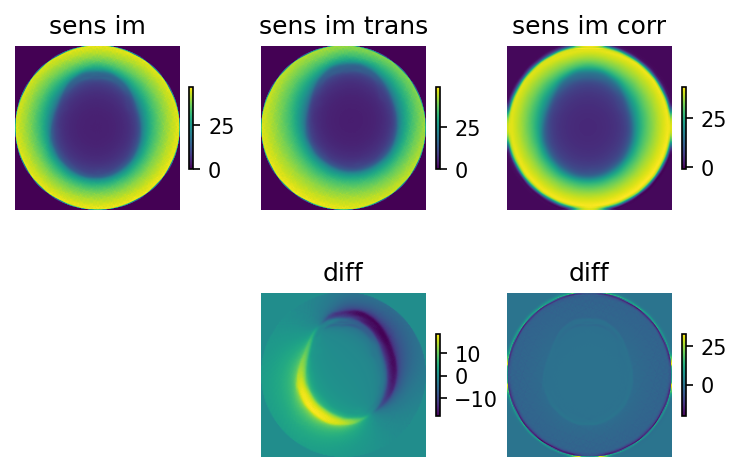

In [ ]:
plot_2d_image([2,3,1], sens_image_brain.as_array()[0,:,:], 'sens im', cmap="viridis")
plot_2d_image([2,3,2], sens_image_brain_new.as_array()[0,:,:], 'sens im trans', cmap="viridis")
plot_2d_image([2,3,3], sens_image_brain_NN.as_array()[0,:,:], 'sens im corr', cmap="viridis")
plot_2d_image([2,3,5], (sens_image_brain_new - sens_image_brain).as_array()[0,:,:], 'diff', cmap="viridis")
plot_2d_image([2,3,6], (sens_image_brain_NN - sens_image_brain).as_array()[0,:,:], 'diff', cmap="viridis")

You can see that we've done a pretty good job here, but not perfect. Again, we're blurred. How can we fix this? 
Let's see how the reconstructions went...

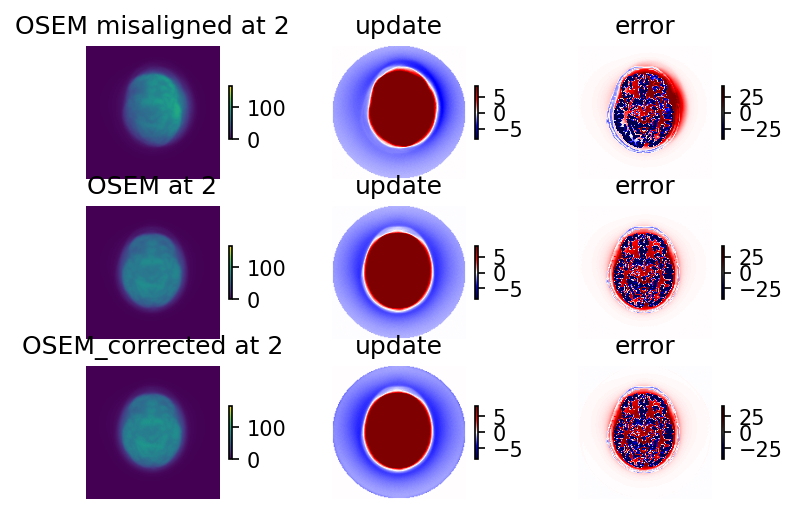

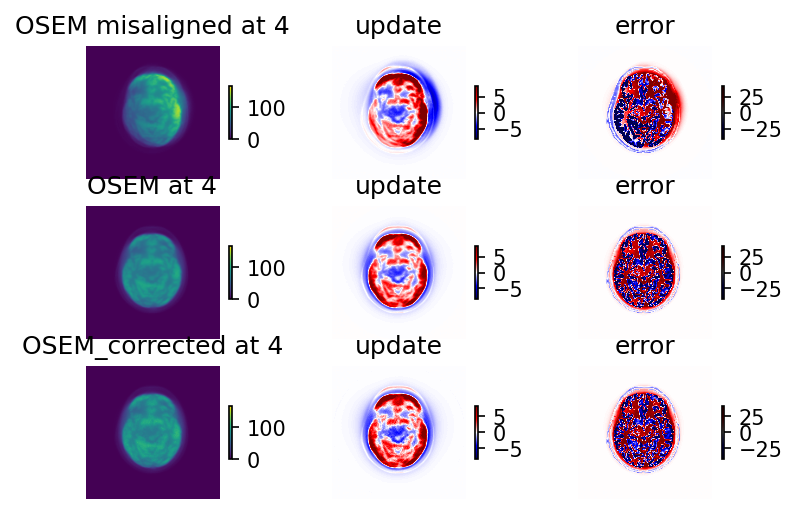

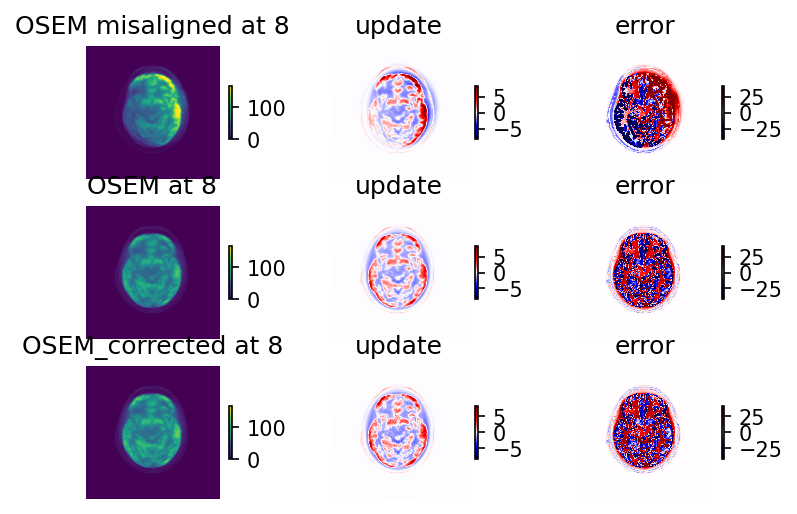

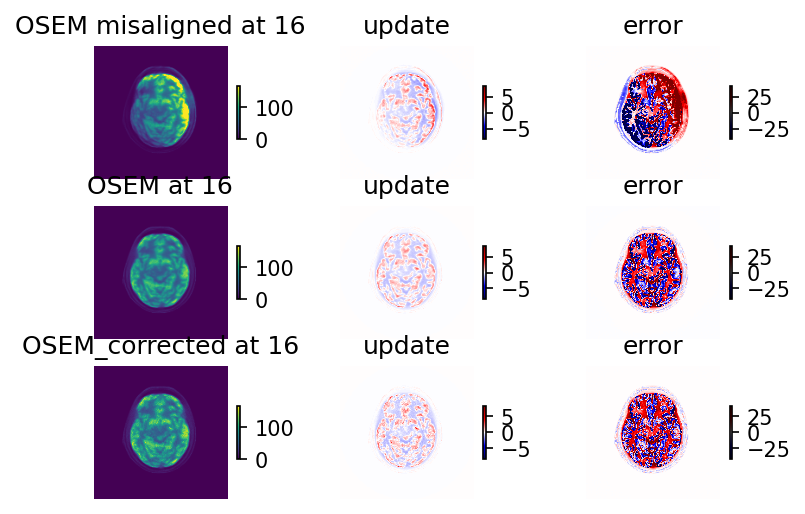

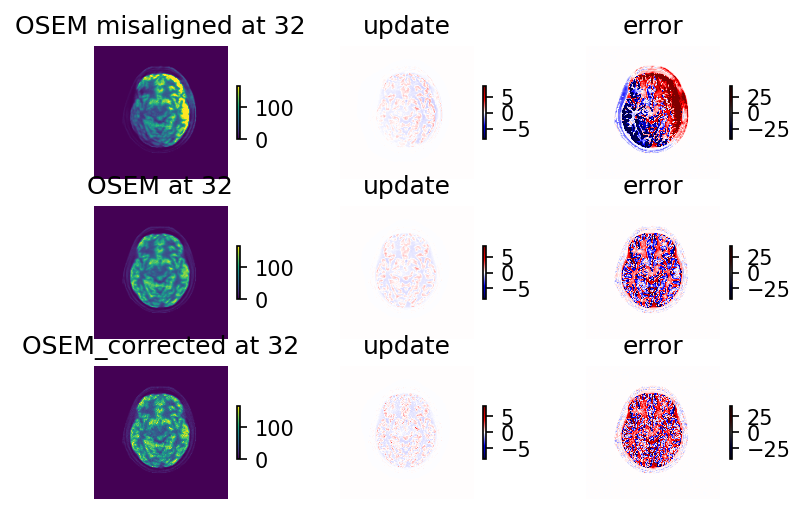

In [ ]:
plot_progress([all_osem_images_brain_new, all_osem_images_brain, all_osem_images_brain_corrected], ['OSEM misaligned' ,'OSEM', 'OSEM_corrected'],fdg_brain_image, [2,4,8,16,32], max = np.max(fdg_brain_2D))

And holy shit it looks like it worked for a brain! Obviously to do this for real images, we will have to do gated corrections, but I think this is a pretty good start! Considering this is only trained on transformed ellipses, I think it's pretty darn good!

# Things to think about
## Why does the output look like this?
### network too deep?
## Are these the best inputs and outputs that we can have?
### Difference images (Kris likes this)

### And many more...

Try this for a better UNet:
https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-model-building-6ab09d6a0862